# Credits to Zero to Mastery Online courses and the instructor Daniel Bourke
https://academy.zerotomastery.io/courses/
# Course Notes
https://github.com/mrdbourke/tensorflow-deep-learning

# ***MvP 4***

We successfully created our multiclass classification with a over 81% accuracy. But what happen if we want to import even more classes of food, like maybe 100 classes of food for example?

Since multiclass classification's last model took a considerable long time, we need to find a better method to handle this.

# **Transfer Learning**

* Can leverage an existing neural network architecture proven to work on problems similar to our own.
* Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [ ]:
from IPython.display import Image
import zipfile
import os
import pathlib
import numpy as np
import glob
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
## Get the function ipynb file for reusing of codes
!wget https://github.com/DSstore/AIP/raw/main/functions.ipynb

--2022-02-15 10:23:15--  https://github.com/DSstore/AIP/raw/main/functions.ipynb
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DSstore/AIP/main/functions.ipynb [following]
--2022-02-15 10:23:15--  https://raw.githubusercontent.com/DSstore/AIP/main/functions.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10225 (10.0K) [text/plain]
Saving to: ‘functions.ipynb’

functions.ipynb     100%[===================>]   9.99K  --.-KB/s    in 0s      

2022-02-15 10:23:15 (77.0 MB/s) - ‘functions.ipynb’ saved [10225/10225]



In [ ]:
#Install import_ipynb function in order to use ipynb as seperate function calls 
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=396418667ddb5abf7549e9dd80b6ce6f4c5b9648e4a1a5c76ed26ae7d469052b
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import import_ipynb
import functions as fn

importing Jupyter notebook from functions.ipynb
16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
# Download data
!wget https://storage.googleapis.com/sgfood/SG_Food_Big_Pic.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("SG_Food_Big_Pic.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-02-15 10:23:31--  https://storage.googleapis.com/sgfood/SG_Food_Big_Pic.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 741153385 (707M) [application/x-zip-compressed]
Saving to: ‘SG_Food_Big_Pic.zip’

SG_Food_Big_Pic.zip 100%[===================>] 706.82M  35.0MB/s    in 27s     

2022-02-15 10:24:01 (26.0 MB/s) - ‘SG_Food_Big_Pic.zip’ saved [741153385/741153385]



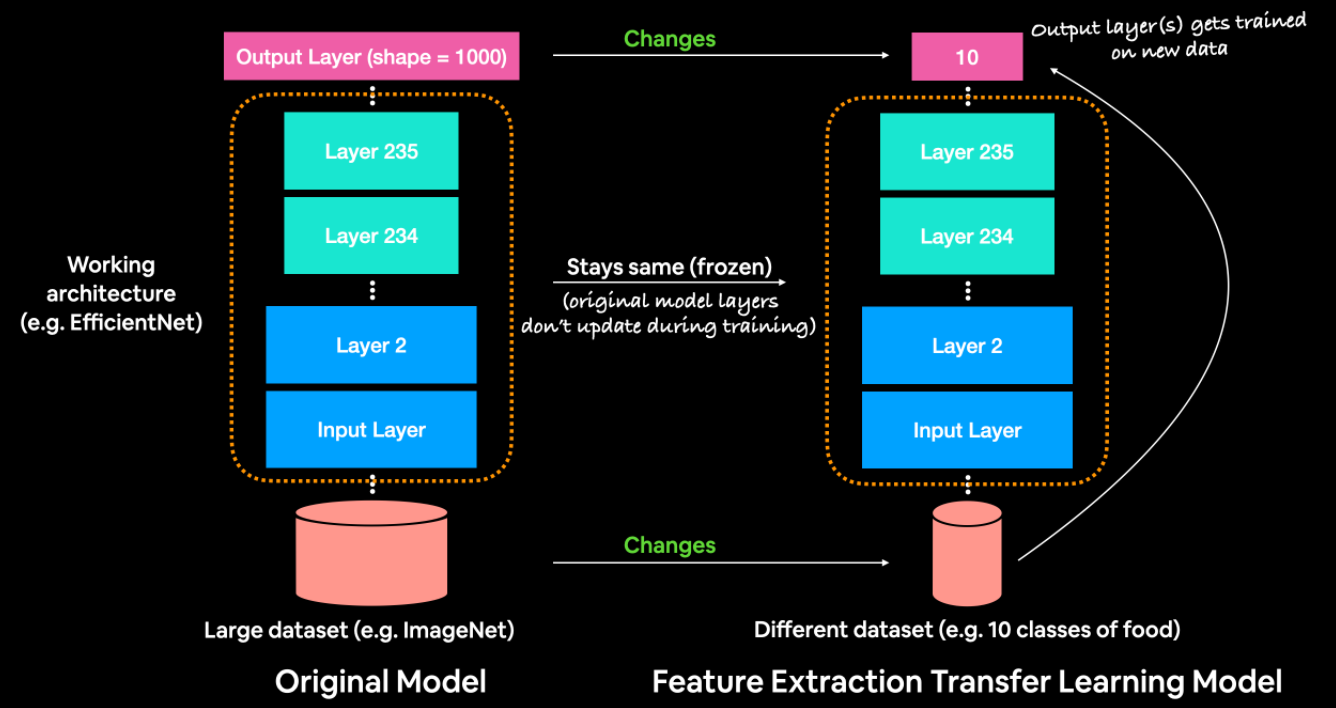

In [ ]:
#Source: Online lecture notes from https://academy.zerotomastery.io/courses/1240775/lectures/
Image("https://github.com/DSstore/AIP/raw/main/transferlearning.png")

What we're working towards building. Taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset our own images.

In [ ]:
# How many images in each folder?

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("SG_Food_Big_Pic"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'SG_Food_Big_Pic'.
There are 20 directories and 0 images in 'SG_Food_Big_Pic/test'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/kiwi'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/apple'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/roti prata'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/oyster omelette'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/laksa'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/char kway teow'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/pear'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/banana'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/satay'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/pineapple'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/chendol'.
There are 0 directories and 25 images in 'SG_Food_Big_Pic/test/Hai

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

In [ ]:
# Setup data inputs

train_dir = "SG_Food_Big_Pic/train/"
test_dir = "SG_Food_Big_Pic/test/"
val_dir = "SG_Food_Big_Pic/validation/"

In [ ]:
# Get the class names for our multi-class dataset

data_dir = pathlib.Path(train_dir)
train_filepaths = list(data_dir.glob(r'**/*.jpg'))
test_data_dir = pathlib.Path(test_dir)
test_filepaths = list(test_data_dir.glob(r'**/*.jpg'))
val_data_dir = pathlib.Path(val_dir)
val_filepaths = list(val_data_dir.glob(r'**/*.jpg'))
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

In [ ]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
#Checking the d
train_df

Filepath           Label
0     SG_Food_Big_Pic/train/char kway teow/char_kway...  char kway teow
1     SG_Food_Big_Pic/train/bak kut teh/bak_kut_teh_...     bak kut teh
2       SG_Food_Big_Pic/train/laksa/laksa_big_pic70.jpg           laksa
3            SG_Food_Big_Pic/train/kiwi/kiwi_train4.jpg            kiwi
4       SG_Food_Big_Pic/train/laksa/laksa_big_pic61.jpg           laksa
...                                                 ...             ...
1495         SG_Food_Big_Pic/train/kiwi/kiwi_train8.jpg            kiwi
1496    SG_Food_Big_Pic/train/satay/satay_big_pic48.jpg           satay
1497  SG_Food_Big_Pic/train/nasi lemak/nasi_lemak_bi...      nasi lemak
1498     SG_Food_Big_Pic/train/grapes/grapes_train5.jpg          grapes
1499  SG_Food_Big_Pic/train/roti prata/roti_prata_bi...      roti prata

[1500 rows x 2 columns]

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255)

print("Agumented Training images:")
train_data_augmented = train_datagen_augmented.flow_from_dataframe(dataframe=train_df,
                                                                   x_col='Filepath',
                                                                   y_col='Label',
                                                                   color_mode='rgb',
                                                                  target_size=IMAGE_SHAPE,
                                                                  batch_size=BATCH_SIZE,
                                                                  class_mode='categorical')


train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)



print("Training images:")
train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                              x_col='Filepath',
                                              y_col='Label',
                                              color_mode='rgb',
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical')

print("Testing images:")
test_data = test_datagen.flow_from_dataframe(dataframe=test_df,
                                              x_col='Filepath',
                                              y_col='Label',
                                              color_mode='rgb',
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical')

print("Validation images:")
val_data = val_datagen.flow_from_dataframe(dataframe=test_df,
                                              x_col='Filepath',
                                              y_col='Label',
                                              color_mode='rgb',
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical')

Agumented Training images:
Found 1500 validated image filenames belonging to 20 classes.
Training images:
Found 1500 validated image filenames belonging to 20 classes.
Testing images:
Found 500 validated image filenames belonging to 20 classes.
Validation images:
Found 500 validated image filenames belonging to 20 classes.


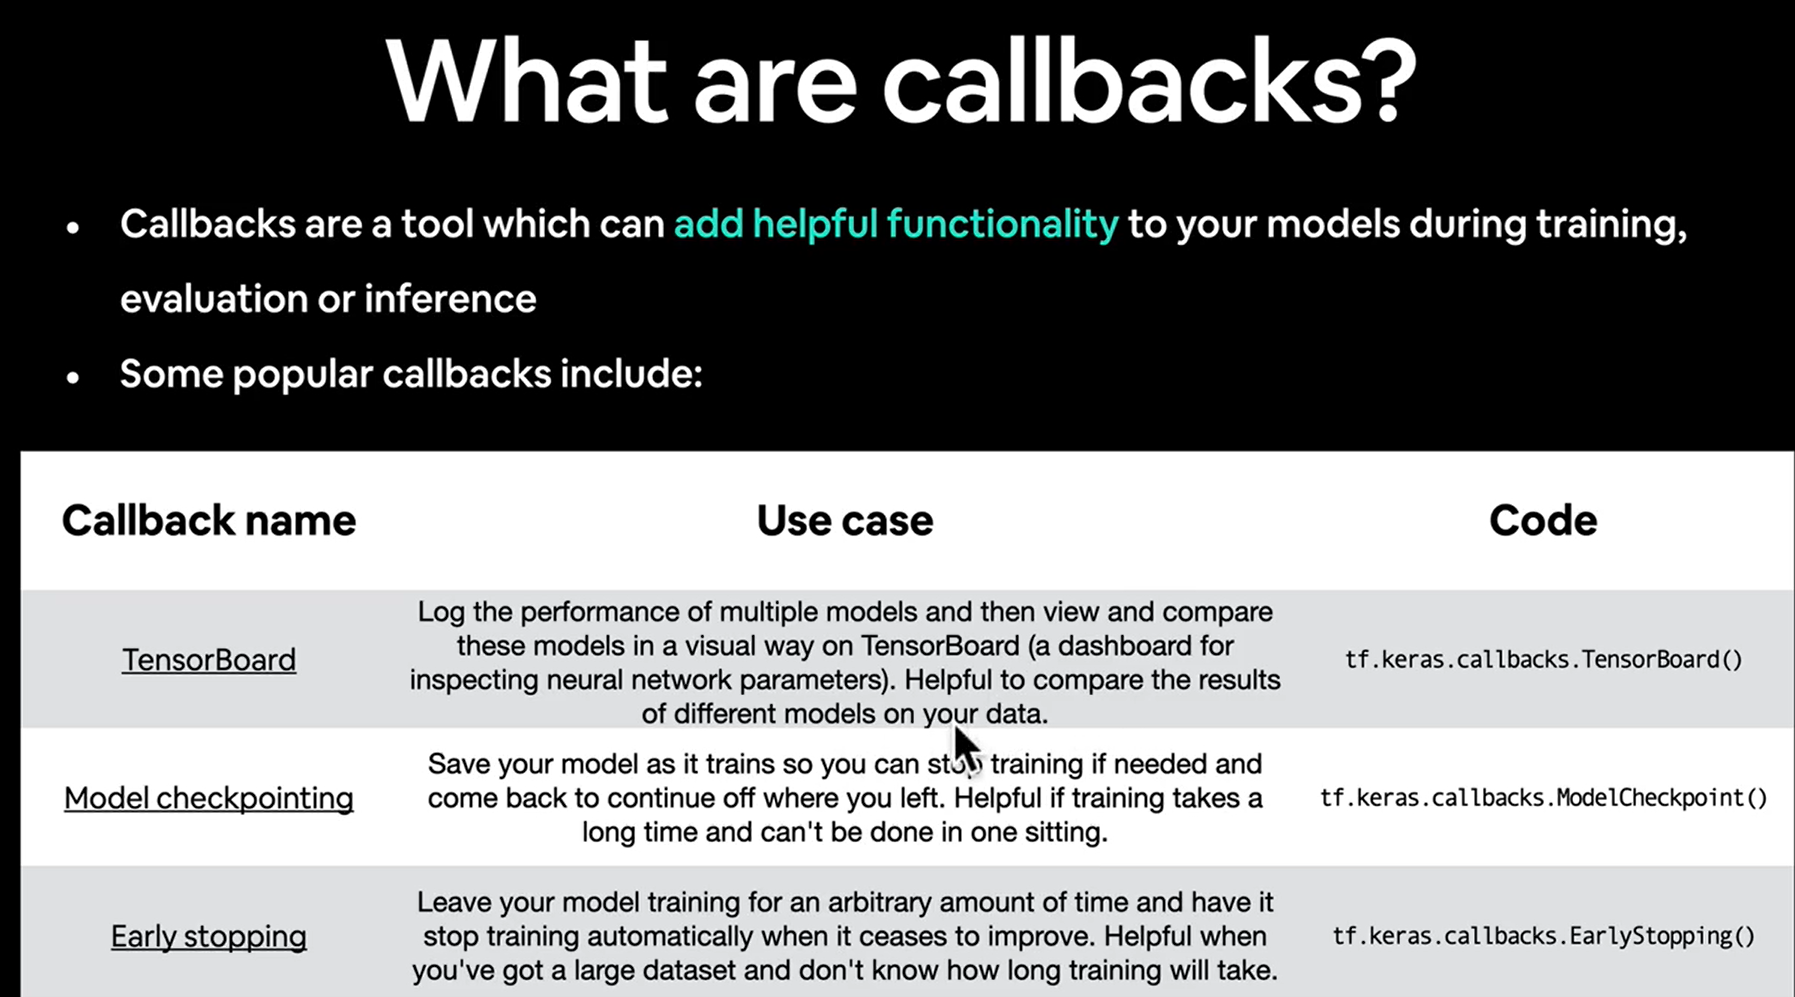

In [ ]:
#Source: Online lecture notes from https://academy.zerotomastery.io/courses/1240775/lectures/
Image("https://github.com/DSstore/AIP/raw/main/callbacks.png")

We will be implementing on Tensorboard to find out what are the changes have been improved from multiclass classification to our transfer classification.

* The TensorBoard callback can be accessed using tf.keras.callbacks.TensorBoard()

* Its main functionality is saving a model's training performance metrics to a specified log_dir.

* By default, logs are recorded every epoch using the update_freq='epoch' parameter. This is a good default since tracking model performance too often can slow down model training.

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

To track our modelling improvements, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run)

In our case, our function saves a model's performance logs to a directory named [dir_name]/[experiment_name]/[current_timestamp], where:

* dir_name is the overall logs directory
* experiment_name is the particular experiment
* current_timestamp is the time the experiment started based on Python's datetime.datetime().now()

# Create Model using TensorFlow Hub



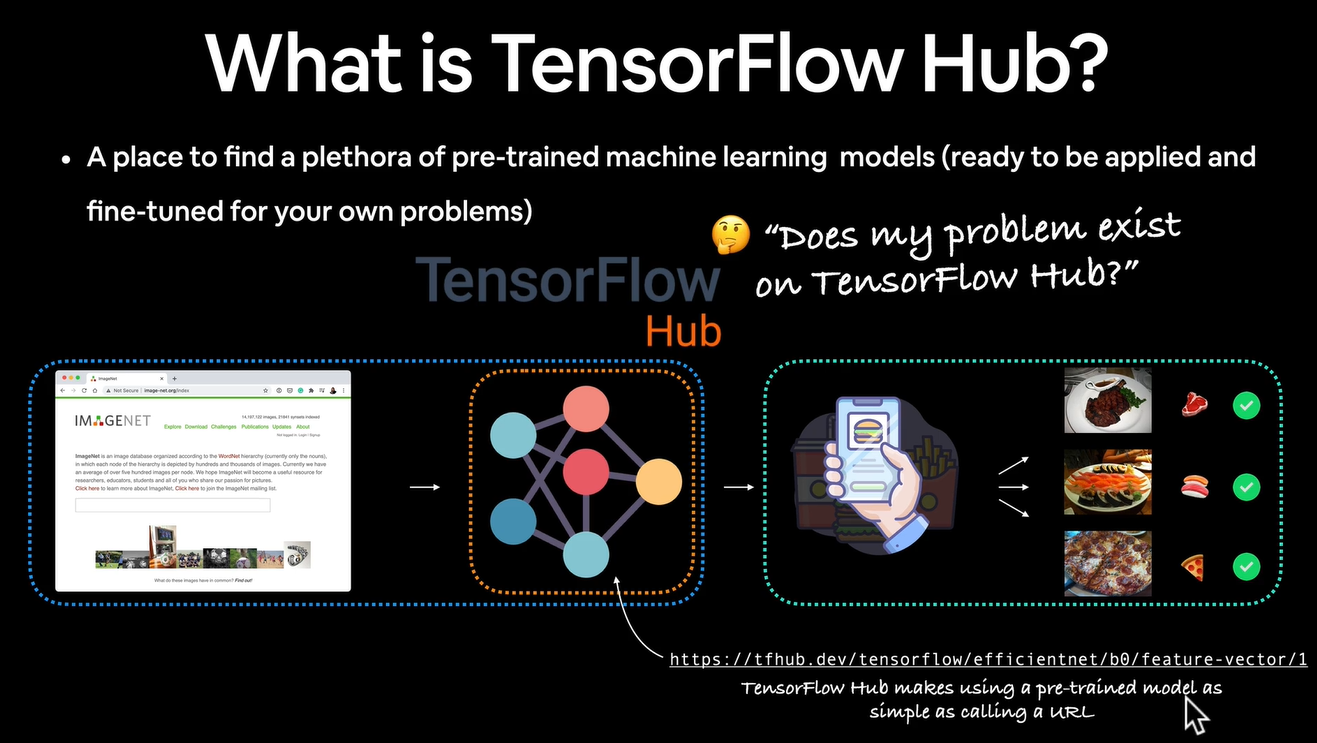

In [ ]:
#Source: Online lecture notes from https://academy.zerotomastery.io/courses/1240775/lectures/
Image("https://github.com/DSstore/AIP/raw/main/whatistensorhub.png")

* Creating model from the tensorflow hub (specifically from https://tfhub.dev/)

* Choose our problem domain, eg "images" (Food images in our case)

* Choose our TF version (TF2 in our case)

* Remove all problem domain filter except the problem we working on

We are going to use two of the recommended transfer learning model and see which one gives us the best results accordingly to our food classification problem

* EfficientNets -  are a family of image classification models, which achieve state-of-the-art accuracy, yet being an order-of-magnitude smaller and faster than previous models.

* ResNet (later renamed ResNet V1) - is a family of network architectures for image classification with a variable number of layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

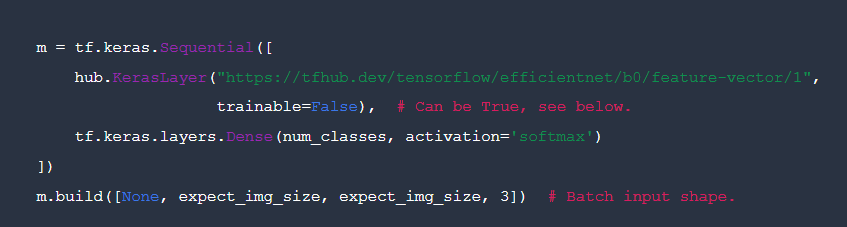

In [ ]:
Image("https://github.com/DSstore/AIP/raw/main/tensorhub5.png")

Using the usage instructions given by the tensor hub, we can use it on how to create our model.

Creating a function to reuse the model

# Creating and testing model ResNet_v2_50 Tensorflow Hub Feature Extraction Model

In [ ]:
def create_model(model_url, num_classes=20):  #num_classes refers to number of inputs
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=20)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 20)                40980     
                                                                 
Total params: 23,605,780
Trainable params: 40,980
Non-trainable params: 23,564,800
_________________________________________________________________


Note the trainable params and non-trainable params. 
The only trainable params are our output layer which has a total of 20,490

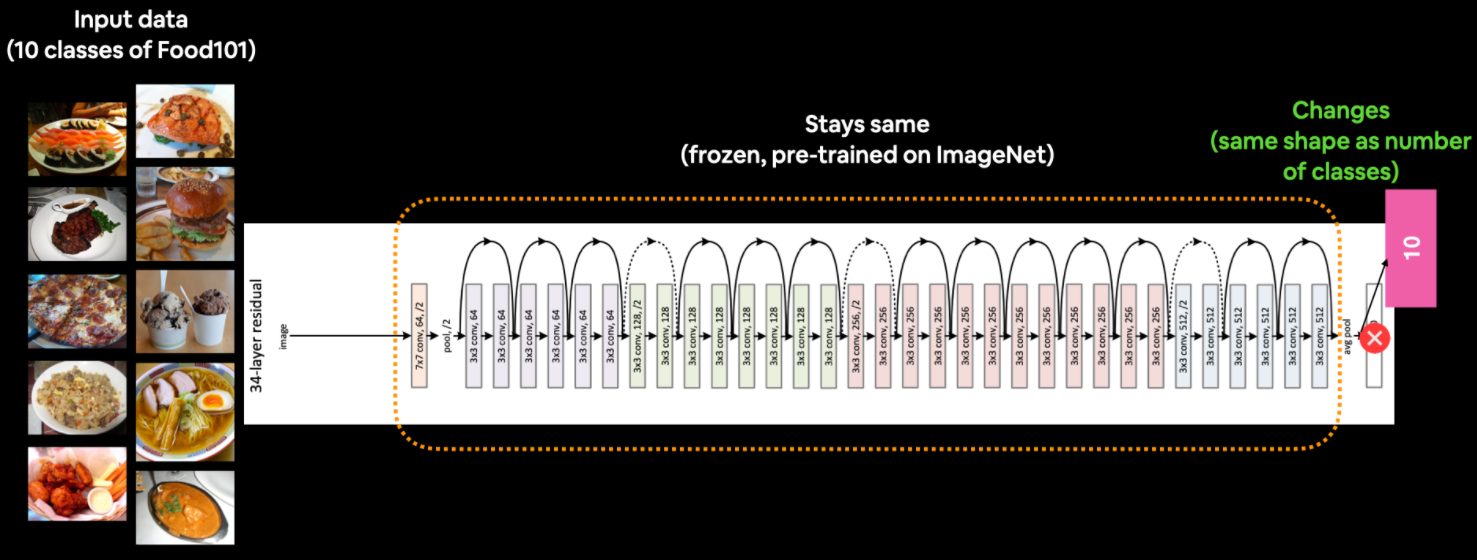

In [ ]:
#Source: Online lecture notes from https://academy.zerotomastery.io/courses/1240775/lectures/
Image("https://github.com/DSstore/AIP/raw/main/Resnet.png")

This is what our current model might looks like. A ResNet50V2 backbone with a custom dense layer on top (10 classes instead of 1000 ImageNet classes)

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=val_data,
                                  validation_steps=len(val_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220214-123252
Epoch 1/5
 3/47 [>.............................] - ETA: 40s - loss: 3.8061 - accuracy: 0.0625

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/47 [==============>...............] - ETA: 23s - loss: 2.2514 - accuracy: 0.3455

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


47/47 [==============================] - 58s 1s/step - loss: 1.6210 - accuracy: 0.5360 - val_loss: 0.9370 - val_accuracy: 0.7180
Epoch 2/5
47/47 [==============================] - 53s 1s/step - loss: 0.4292 - accuracy: 0.8993 - val_loss: 0.6827 - val_accuracy: 0.7900
Epoch 3/5
47/47 [==============================] - 53s 1s/step - loss: 0.2562 - accuracy: 0.9500 - val_loss: 0.6179 - val_accuracy: 0.7940
Epoch 4/5
47/47 [==============================] - 53s 1s/step - loss: 0.1756 - accuracy: 0.9740 - val_loss: 0.5908 - val_accuracy: 0.8160
Epoch 5/5
47/47 [==============================] - 53s 1s/step - loss: 0.1253 - accuracy: 0.9887 - val_loss: 0.5683 - val_accuracy: 0.8200


It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 75 training images.

That goes to show the power of transfer learning. 

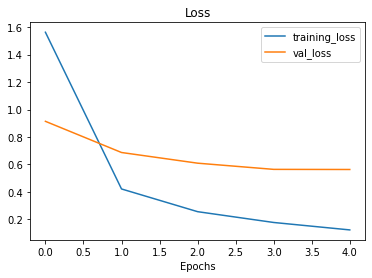

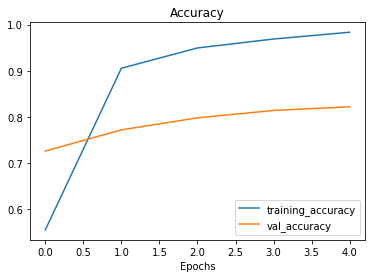

In [ ]:
fn.plot_loss_curves(resnet_history)

This shows that our model is actually overfitting as our validation loss is increasing while our training loss is decreasing as it learning the training data too well.

# Creating and testing model EfficientNetB0 Tensorflow Hub Feature Extraction Model

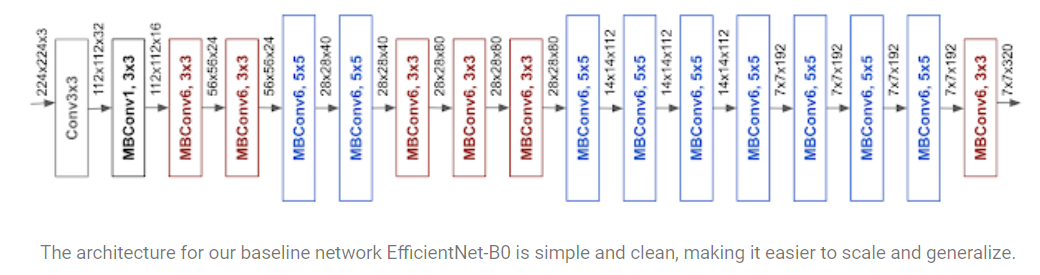

In [ ]:
#Source from https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
Image("https://github.com/DSstore/AIP/raw/main/efficientnet.png")

This is our efficientnet-B0 architecture that we will be using for our transfer learning

In [ ]:
# Create model
efficientnet_model_1 = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=20)

# Compile EfficientNet model
efficientnet_model_1.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history_1 = efficientnet_model_1.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=val_data,
                                              validation_steps=len(val_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220215-102534
Epoch 1/5
 4/47 [=>............................] - ETA: 37s - loss: 2.9133 - accuracy: 0.0859

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/47 [=========>....................] - ETA: 36s - loss: 2.4407 - accuracy: 0.3272

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


47/47 [==============================] - 81s 1s/step - loss: 1.6872 - accuracy: 0.6253 - val_loss: 1.0072 - val_accuracy: 0.8040
Epoch 2/5
47/47 [==============================] - 61s 1s/step - loss: 0.5717 - accuracy: 0.9307 - val_loss: 0.6577 - val_accuracy: 0.8520
Epoch 3/5
47/47 [==============================] - 61s 1s/step - loss: 0.3436 - accuracy: 0.9553 - val_loss: 0.5227 - val_accuracy: 0.8780
Epoch 4/5
47/47 [==============================] - 61s 1s/step - loss: 0.2481 - accuracy: 0.9687 - val_loss: 0.4618 - val_accuracy: 0.8840
Epoch 5/5
47/47 [==============================] - 62s 1s/step - loss: 0.1953 - accuracy: 0.9807 - val_loss: 0.4187 - val_accuracy: 0.8940


As we can see, the accuracy increased by nearly 10% given the same number of output parameters and epochs. This is this particular tensorhub model is suited for our problem.

In [ ]:
# Save a model in h5
efficientnet_model_1.save("efficientnet_model_1.h5")

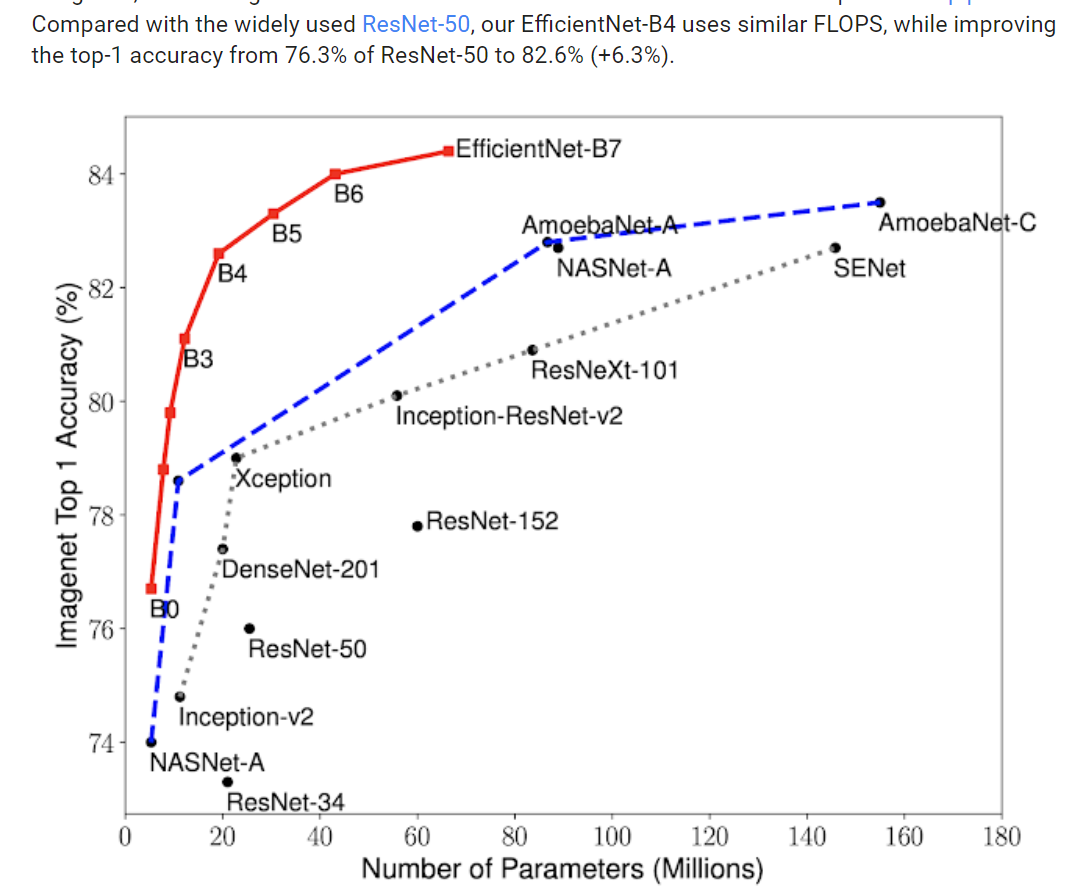

In [ ]:
#Source from https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
Image("https://github.com/DSstore/AIP/raw/main/Efficientnetaccuracy.png")

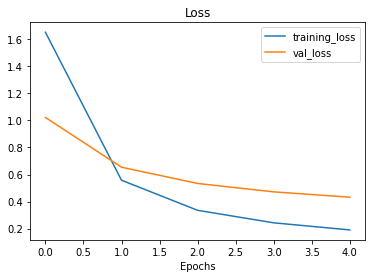

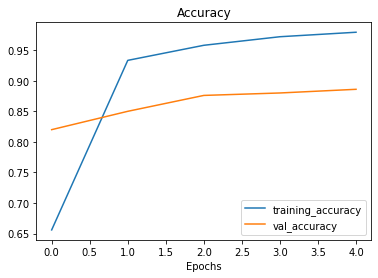

In [ ]:
fn.plot_loss_curves(efficientnet_history_1)

Looks like we can even push the epochs to even higher because based how closely the val_loss and training loss is.

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 20)                40980     
                                                                 
Total params: 23,605,780
Trainable params: 40,980
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
efficientnet_model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 20)                25620     
                                                                 
Total params: 4,075,184
Trainable params: 25,620
Non-trainable params: 4,049,564
_________________________________________________________________


Comparing the two models, we can see that resnet uses nearly 6 times more parameters while still outperform by efficientnet model. Hence its clear to say that EfficientNet is the clear winner.

In [ ]:
# Authentic Colab 
# (running this will give you a code to authentic your Google Colab instance, keep the code secret)
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Install and initialize the gcloud command line tool - https://cloud.google.com/sdk/docs/install
# (this will give you access to gcloud tools within Colab)
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   443  100   443    0     0  10804      0 --:--:-- --:--:-- --:--:-- 10547
######################################################################## 100.0%
which curl
curl -# -f https://dl.google.com/dl/cloudsdk/channels/rapid/google-cloud-sdk.tar.gz
######################################################################## 100.0%
mkdir -p /root
tar -C /root -zxvf /tmp/tmp.bToAm6gfdu/google-cloud-sdk.tar.gz
/root/google-cloud-sdk/install.sh
Beginning update. This process may take several minutes.


Your current Google Cloud CLI version is: 372.0.0
Installing components from version: 372.0.0

┌─────────────────────────────────────────────────────────────────────────────┐
│                     These components will be installed.                     │
├─────────────────────────────────────────────────────┬────────────┬──────────┤
│ 

In [ ]:
# Save the model
efficientnet_model_1.save("efficientnet_model_1")

INFO:tensorflow:Assets written to: efficientnet_model_1/assets


INFO:tensorflow:Assets written to: efficientnet_model_1/assets


In [ ]:
# Copy model to bucket - https://cloud.google.com/storage/docs/uploading-objects#gsutil 
# Use "-r" for folders (r stands for recursive)
!gsutil cp -r efficientnet_model_1 gs://food_model

Copying file://efficientnet_model_1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
|
Operation completed over 4 objects/23.0 MiB.                                     


# #So how many layers does EfficientNet has in total ?

In [ ]:
#Breaking down the layers
efficientnet_model_1.layers

**tensorflow_hub.keras_layer.KerasLayer at 0x7fa248ca2110** -> This is the tensorhub layers

**keras.layers.core.dense.Dense at 0x7f9fdf548450** -> While this is our output layer

In [ ]:
efficientnet_model_1.layers[0]

In [ ]:
efficientnet_model_1.layers[0].weights

[<tf.Variable 'stem_conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.27994761e-02,
            2.23197415e-02, -1.42137900e-01],
          [ 1.28902495e-02,  1.56575632e+00, -1.80467033e+00,
            7.77730107e-01,  6.52952865e-02,  2.08790317e-01,
           -8.81190374e-02, -3.78276139e-01,  5.80090940e-01,
           -3.44047934e-01,  6.91463649e-02, -8.79267603e-02,
       

In [ ]:
len(efficientnet_model_1.layers[0].weights)

309

So our efficientnet tensorhub model has 309 layers
In our multiclass classification, our best model has 18 layers. We can imagine the time spent and effort put into this efficientnet tensorhub model so that we can use the pretrained knowledge to apply to our problem.

# Comparing model's Results

Note: if upload things to tensorboard, all the data in there will be public

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=B5osu4UyCW30bXubVcwwywO33FGtTk&prompt=consent&access_type=off

* --logdir is the target upload directory
* --name is the name of the experiment
* --description is a brief description of the experiment
* --one_shot exits the TensorBoard uploader once uploading is finished

In [ ]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/ip5YOf8ATJOUxjuMAHMA4Q/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   ip5YOf8ATJOUxjuMAHMA4Q
	Created              2022-02-13 18:46:22 (5 minutes ago)
	Updated              2022-02-13 18:46:27 (5 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              132
	Tensor bytes         0
	Binary object bytes  13687798
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id jELLvMc2Tk60LdFPbfwrsA

Deleted experiment jELLvMc2Tk60LdFPbfwrsA.


# With MvP 4 completed, we can finally go to our final MvP with EfficientNet.